In [ ]:
def lens(*args):
    'returns the lengths of objects'
    return list(map(len, args))

In [ ]:
import os

Change the working directory to where the data files are located

In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/green')

In [ ]:
pwd

'/content/drive/My Drive/Colab Notebooks/green'

## Install required libraries

In [ ]:
pip install pystan

In [ ]:
pip install fbprophet

In [ ]:
from fbprophet import Prophet


In [ ]:
import pandas as pd
import numpy as np

## Load and checkout the data

In [ ]:
df_tr = pd.read_csv('Hourly-train.csv')

In [ ]:
df_tr.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,...,V922,V923,V924,V925,V926,V927,V928,V929,V930,V931,V932,V933,V934,V935,V936,V937,V938,V939,V940,V941,V942,V943,V944,V945,V946,V947,V948,V949,V950,V951,V952,V953,V954,V955,V956,V957,V958,V959,V960,V961
0,H1,605.0,586.0,586.0,559.0,511.0,443.0,422.0,395.0,382.0,370.0,383.0,397.0,420.0,455.0,493.0,554.0,610.0,666.0,715.0,755.0,778.0,794.0,806.0,808.0,776.0,723.0,709.0,660.0,585.0,527.0,462.0,437.0,413.0,407.0,404.0,420.0,441.0,471.0,526.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,H2,3124.0,2990.0,2862.0,2809.0,2544.0,2201.0,1996.0,1861.0,1735.0,1713.0,1724.0,1798.0,1891.0,2037.0,2102.0,2163.0,2269.0,2404.0,2515.0,2621.0,2745.0,2816.0,2938.0,3022.0,2976.0,2892.0,2784.0,2725.0,2530.0,2211.0,1995.0,1833.0,1768.0,1712.0,1707.0,1762.0,1880.0,1995.0,2134.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H3,1828.0,1806.0,1897.0,1750.0,1679.0,1620.0,1463.0,1342.0,1192.0,1108.0,1058.0,1024.0,1031.0,1091.0,1208.0,1337.0,1435.0,1515.0,1593.0,1667.0,1753.0,1768.0,1823.0,1813.0,1842.0,1838.0,1800.0,1761.0,1670.0,1609.0,1467.0,1309.0,1189.0,1102.0,1054.0,1017.0,1014.0,1063.0,1187.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H4,6454.0,6324.0,6075.0,5949.0,5858.0,5579.0,5163.0,4790.0,4478.0,4227.0,4016.0,3879.0,3821.0,3823.0,3960.0,4169.0,4377.0,4597.0,4864.0,5183.0,5440.0,5707.0,5937.0,6089.0,6097.0,6018.0,5783.0,5655.0,5581.0,5320.0,4909.0,4509.0,4189.0,3964.0,3794.0,3680.0,3682.0,3693.0,3851.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H5,4263.0,4297.0,4236.0,4080.0,3883.0,3672.0,3248.0,2841.0,2513.0,2275.0,2104.0,1988.0,1958.0,2006.0,2076.0,2209.0,2372.0,2599.0,2880.0,3127.0,3297.0,3506.0,3667.0,3752.0,3842.0,3851.0,3728.0,3578.0,3421.0,3252.0,2910.0,2559.0,2293.0,2104.0,1974.0,1893.0,1896.0,1970.0,2053.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_tr.shape

(414, 961)

In [ ]:
df_te = pd.read_csv('datasets_546263_996339_Hourly-test.csv')

In [ ]:
df_te.shape

(414, 49)

In [ ]:
df_te.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49
0,H1,619.0,565.0,532.0,495.0,481.0,467.0,473.0,488.0,501.0,534.0,576.0,639.0,712.0,772.0,830.0,880.0,893.0,896.0,891.0,854.0,803.0,769.0,751.0,701.0,635.0,572.0,532.0,493.0,477.0,468.0,464.0,477.0,492.0,519.0,568.0,624.0,696.0,761.0,812.0,836.0,838.0,829.0,807.0,785.0,756.0,719.0,703.0,659.0
1,H2,2771.0,2396.0,2189.0,1984.0,1872.0,1843.0,1828.0,1872.0,1952.0,2069.0,2228.0,2419.0,2640.0,2850.0,3001.0,3129.0,3244.0,3295.0,3322.0,3322.0,3286.0,3092.0,2936.0,2825.0,2519.0,2197.0,1997.0,1775.0,1725.0,1630.0,1644.0,1722.0,1808.0,1961.0,2154.0,2355.0,2605.0,2821.0,3018.0,3206.0,3356.0,3499.0,3550.0,3558.0,3488.0,3224.0,3054.0,2918.0
2,H3,1455.0,1376.0,1235.0,1101.0,1003.0,943.0,905.0,886.0,910.0,970.0,1071.0,1170.0,1225.0,1306.0,1373.0,1442.0,1542.0,1611.0,1673.0,1711.0,1754.0,1757.0,1735.0,1667.0,1585.0,1473.0,1317.0,1177.0,1060.0,1000.0,951.0,917.0,924.0,979.0,1073.0,1195.0,1281.0,1371.0,1457.0,1529.0,1627.0,1701.0,1754.0,1791.0,1819.0,1791.0,1758.0,1679.0
3,H4,5327.0,5051.0,4683.0,4319.0,4049.0,3847.0,3712.0,3639.0,3652.0,3758.0,3857.0,4082.0,4363.0,4631.0,4915.0,5201.0,5442.0,5738.0,5993.0,6195.0,6290.0,6284.0,6126.0,5968.0,5818.0,5516.0,5074.0,4658.0,4337.0,4106.0,3922.0,3804.0,3794.0,3853.0,3993.0,4284.0,4575.0,4925.0,5337.0,5675.0,5926.0,6159.0,6313.0,6072.0,5612.0,5220.0,4895.0,4793.0
4,H5,3823.0,3501.0,3039.0,2613.0,2312.0,2079.0,1938.0,1839.0,1821.0,1877.0,1951.0,2062.0,2182.0,2353.0,2562.0,2826.0,3100.0,3431.0,3689.0,3900.0,4049.0,4056.0,3931.0,3682.0,3471.0,3200.0,2810.0,2461.0,2199.0,2004.0,1873.0,1791.0,1788.0,1853.0,1926.0,1996.0,2067.0,2174.0,2345.0,2529.0,2737.0,3028.0,3292.0,3453.0,3574.0,3522.0,3338.0,3041.0


# Part 1 & Part 2


In [ ]:
input_size = int(48*1.25)  # input sequence size
max_forecast_horizon = 48  # output sequence size

In [ ]:
def create_windows_inout(dataset, input_size, out_size=48):
	'Moving Window Transformation of the dataset, returns the sequences X and y'
	dataX = []
	dataY = []
	for i in range(len(dataset)-out_size-1):
		x = dataset[i:(i+input_size)]  
		y = dataset[i+input_size : i+input_size+out_size]
		if len(x)!=60 or len(y) != 48:
			break
		dataX.append(x)
		dataY.append(y)
	return np.array(dataX), np.array(dataY)
	# return dataX, dataY


In [ ]:
def create_windows_season(season_vect, window_size=48):
    'Moving Window Transformation of the seasonal_vector'
    input_size = 60
    dataY = []
    for i in range(len(season_vect)-window_size-1):
        y = season_vect[i+input_size : (i+input_size+window_size)]  
        if len(y) != 48:
            break
        dataY.append(y)
    return np.array(dataY)
    # return dataY

## Time Series Pre-processing and Seasonal Decomposition using Prophet

Applying Normalisation, Variance Stabilisation Layer and Moving Window Transformation, Seasonal Decomposition

In [ ]:
%%time
X_train, y_train = [], []
seasonal_vectors = []
time_series_means = []
level_valuess = []
for i in range(len(df_tr)):
    time_series_data = df_tr.iloc[i][1:].dropna()
    time_series_mean = time_series_data.mean()
    time_series_data = time_series_data/time_series_mean # Normalisation

    time_series_log = np.log(time_series_data.astype('float32') + 1) # Variance Stabilisation Layer
    time_series_length = len(time_series_log)
    history = pd.DataFrame({
        'ds': pd.date_range('2010-01-01', periods=len(time_series_log), freq='H'),
        'y': time_series_log
    })
    m = Prophet(yearly_seasonality=True)
    m.fit(history)
    future = m.make_future_dataframe(periods=0)
    forecast = m.predict(future)
    seasonal_vect = forecast['daily'] + forecast['weekly'] + forecast['yearly']
    levels_vect = forecast['trend']
    residuals = np.array(time_series_log) - forecast['yhat']
    values_vect = residuals + (levels_vect) # trend + residuals

    # Moving Window Transformation
    X, Y = create_windows_inout(list(values_vect), int(input_size))
    seas_vects = create_windows_season(list(seasonal_vect))

    level_values = np.array(levels_vect[input_size : (time_series_length - max_forecast_horizon +1)])
    X = np.subtract(X, level_values.reshape(-1, 1))
    Y = np.subtract(Y, level_values.reshape(-1, 1))

    level_valuess.extend(level_values.tolist())
    time_series_means.extend([time_series_mean]*len(seas_vects))
    X_train.extend(X.tolist())
    y_train.extend(Y.tolist())
    seasonal_vectors.extend(seas_vects.tolist())
    # if i==5: # creating a shorter dataset/dummy dataset as sample dataset
    break

CPU times: user 3.95 s, sys: 2.59 s, total: 6.54 s
Wall time: 3.62 s


Checking the lengths of the sequences

In [ ]:
lens(level_valuess, X,Y)

[593, 593, 593]

In [ ]:
lens( forecast['yhat'], time_series_log, history, forecast, seasonal_vect, levels_vect, residuals, values_vect)

[700, 700, 700, 700, 700, 700, 700, 700]

In [ ]:
lens(X_train[-1], y_train[-1], seasonal_vectors[-1])

[60, 48, 48]

In [ ]:
lens(X_train[1], y_train[1], seasonal_vectors[1])

[60, 48, 48]

In [ ]:
lens(X_train, y_train, seasonal_vectors, time_series_means)

[593, 593, 593, 593]

## Visualize Seasonal Decomposition by decomposing

In [ ]:
m = Prophet(yearly_seasonality=True)
m.fit(history)
future = m.make_future_dataframe(periods=0)
forecast = m.predict(future)


Visualize working of the implemented Seasonal Decomposition technique by decomposing an Observed time series into its Trend, Seasonal and residual patterns

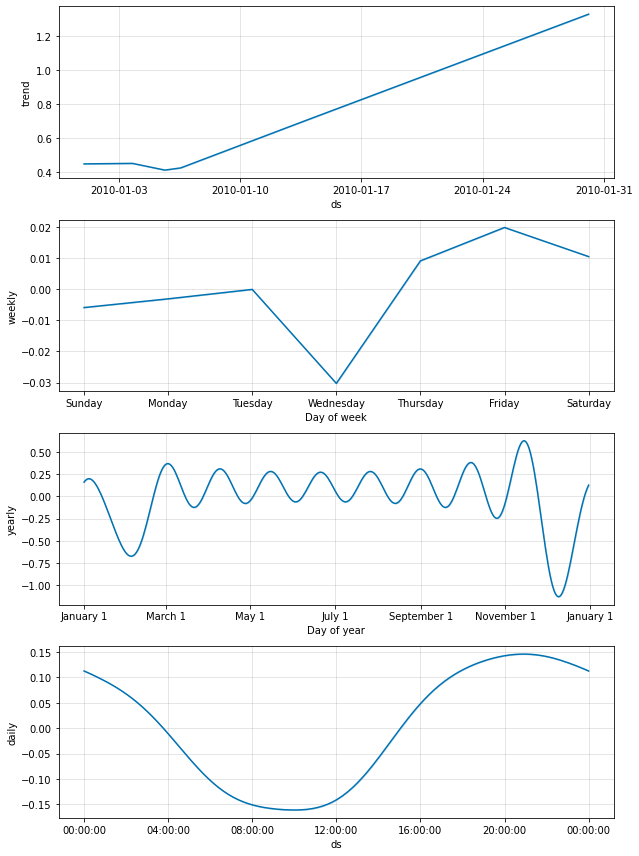

In [ ]:
fig1 = m.plot_components(forecast)

## Creating and saving the dataset

In [ ]:
df_x_y_seasonal_comp = pd.DataFrame({
    'x': X_train,
    'y': y_train,
    'seasonal_vectors': seasonal_vectors,
    'time_series_means': time_series_means,
    'level_values': level_valuess
})

In [ ]:
df_x_y_seasonal_comp.head()

,x,y,seasonal_vectors,time_series_means,level_values
0,"[-0.07319256244758882, -0.06910902964187737, -...","[0.027680311860873885, 0.024897338128175017, 0...","[0.04384572158000452, 0.07772431928273506, 0.1...",638.488571,0.450830
1,"[-0.06915537034073144, -0.044228376278216464, ...","[0.024850997429320953, 0.02437960239619341, 0....","[0.07772431928273506, 0.12739362653204922, 0.1...",638.488571,0.450876
2,"[-0.04427471697707047, -0.03258628999318941, -...","[0.024333261697339403, 0.024489483996463834, 0...","[0.12739362653204922, 0.1838962086495812, 0.23...",638.488571,0.450923
3,"[-0.032632630692043474, -0.0298387303276082, -...","[0.02444314329760977, 0.023703648685737877, 0....","[0.1838962086495812, 0.2359496399718107, 0.276...",638.488571,0.450969
4,"[-0.029885071026462262, -0.042765899503585725,...","[0.023657307986883813, 0.01881994029289552, 0....","[0.2359496399718107, 0.2763163231374482, 0.304...",638.488571,0.451015


In [ ]:
X_train =  np.array(X_train)
y_train =  np.array(y_train)
seasonal_vectors =  np.array(seasonal_vectors)
level_valuess = np.array(level_valuess)

In [ ]:
df_x_y_seasonal_comp.to_csv('x_y_seasonal_comp.csv')

# Part 3

## DataLoader

In [ ]:
import torch

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
np.random.seed(2020)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train , test_size=0.1, random_state=2020)

In [ ]:
# X_train, X_val, y_train, y_val = list(map(list, [X_train, X_val, y_train, y_val]))

In [ ]:
X_train, X_val, y_train, y_val = list(map(torch.tensor, [X_train, X_val, y_train, y_val]))

In [ ]:
X_train, X_val, y_train, y_val = list(map(lambda x: x.float(), [X_train, X_val, y_train, y_val]))

In [ ]:
trn_dataset = TensorDataset(X_train, y_train)

In [ ]:
val_dataset = TensorDataset(X_val, y_val)

In [ ]:
trn_dl = DataLoader(trn_dataset, batch_size=12)

In [ ]:
val_dl = DataLoader(val_dataset, batch_size=12)

In [ ]:
bs = 12 # batch size

# model

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class LSTM_net(nn.Module):
    def __init__(self, input_seq_len=60, hidden_size=20, num_layers = 2, output_seq_len = 48, batch_size=12):
        super().__init__()
        self.batch_size = batch_size
        self.input_seq_len = input_seq_len
        self.output_seq_len = output_seq_len
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=1, hidden_size=20, num_layers = 2, batch_first=True)
        self.linear = nn.Linear(input_seq_len*hidden_size, output_seq_len)

    # def init_hidden(self):
    #     # This is what we'll initialise our hidden state as
    #     return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
    #             torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input_seq):
        out, (hn ,cn) = self.lstm(input_seq)
        y_hat = self.linear(out.reshape(-1, self.input_seq_len * self.hidden_size))
        return y_hat

In [ ]:
model = LSTM_net()

In [ ]:
model = model.float()

# Loss

In [ ]:
def l1_loss(output, target):
    'L1-norm'
    loss = torch.mean(torch.abs(output - target))
    return loss

In [ ]:
def l2_reg_term(model_params):
    'L2-regularization'
    for param in model_params:
        l2_reg += torch.pow(param, 2).sum()
    l2_reg = l2_reg * 0.5
    return l2_reg

The total loss as given in the paper

In [ ]:
def total_loss(output, target, model_params, psi=1e-4):
    loss = l1_loss(output, target) + psi*l2_reg_term(model_params)
    return loss

# Train

In [ ]:
from torch import optim

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)


## util functions for training

In [ ]:
def validation_step(model, batch):
    images, targets = batch 
    out = model(images.reshape(bs,-1, 1))                           # Generate predictions
    loss = total_loss(out, targets, model.parameters())  # Calculate loss
    return {'val_loss': loss.detach() }

In [ ]:
def validation_epoch_end( outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    return {'val_loss': epoch_loss.item()}

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(model, batch) for batch in val_loader]
    return validation_epoch_end(outputs)

In [ ]:
def epoch_end(epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(
        epoch, result['train_loss'], result['val_loss'], ))

In [ ]:
grad_clip = 0.1


In [ ]:
history = []


In [ ]:
epochs = 3

In [ ]:
for epoch in range(epochs):
    train_losses = []
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(trn_dl):
        x, y = [t.to(device) for t in batch]
        x = x.reshape(bs,-1, 1)
        # x = x.double()
        optimizer.zero_grad()
        y_hat = model(x)
        loss = total_loss(y_hat, y, model.parameters())
        train_losses.append(loss)
        out = model(x)
        epoch_loss += loss.item()
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), grad_clip) # Applying gradient clipping
        optimizer.step()


        result = evaluate(model, val_dl)
        result['train_loss'] = torch.stack(train_losses).mean().item()

        epoch_end(epoch, result)

        history.append(result)
        break

Epoch [0], train_loss: 0.0544, val_loss: 0.0382
Epoch [1], train_loss: 0.0375, val_loss: 0.0386
Epoch [2], train_loss: 0.0346, val_loss: 0.0341


## save the model

In [ ]:
torch.save(model.state_dict(), 'LSTM-MSNet.pth')

## Plotting the losses

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

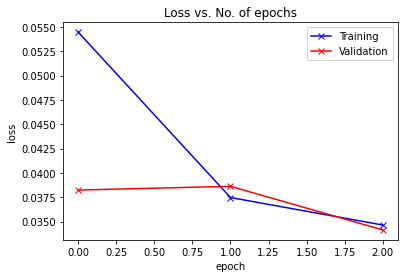

In [ ]:
plot_losses(history)

## Post-processing Layer

### Reseasonalisation & Renormalisation

In [ ]:
renormalised = []
Y_ = []
X_ = []
for i, (x,y,seasonal_vector, time_series_mean, level_value) in df_x_y_seasonal_comp.iterrows():
    # print(i, lens(x,y,season))
    x,y,seasonal_vector, time_series_mean, level_value = list(map(torch.tensor, [x,y,seasonal_vector, time_series_mean, level_value]))
    y_hat = model(x.reshape(1,-1,1))
    reseason = y_hat[0] + seasonal_vector
    # print(reseason)
    # reseasonalised.append(reseason.tolist())
    Y_.append(y.tolist())
    X_.append(x.tolist())

    renormalisation = y_hat[0] + level_value + seasonal_vector 
    renormalisation = renormalisation -1
    renormalisation = torch.exp(renormalisation)
    renormalisation = renormalisation * time_series_mean
    renormalisation[renormalisation <0] = 0
    renormalised.append(renormalisation.tolist())
    if i==5:
        break

# Part 4Part 4


Evaluate the model's performance on the following 4 error metrics

## sMAPE

In [ ]:
def sMAP(F,Y):
    'F - forecsted ,Y- actual'
    return 2*np.mean( np.abs(F - Y) / (np.abs(Y) + np.abs(F)))

Mean of the sMAPEs (Mean sMAPE)

In [ ]:
renormalised, Y_, X_ = list(map(np.array, [renormalised, Y_, X_]))

In [ ]:
SMAPEPerSeries = [sMAPE(f, y) for f,y in zip(renormalised, Y_)]

In [ ]:
mean_SMAPE = np.mean(SMAPEPerSeries)
median_SMAPE = np.median(SMAPEPerSeries)
std_SMAPE = np.std(SMAPEPerSeries)

In [ ]:
print(mean_SMAPE)
print(median_SMAPE)
print(std_SMAPE)

1.9998911952875524
1.9998916011890584
8.303204567851873e-06


## MASE

In [ ]:
def MASE(X,Y, F):
    n = X.shape[0]
    d = np.abs(  np.diff( X) ).sum()/(n-1)
    
    errors = np.abs(Y - F )
    return errors.mean()/d

In [ ]:
MASEPerSeries = [MASE(x,y,f) for x,y,f in zip(X_, Y_, renormalised )]

In [ ]:
mean_MASE = np.mean(MASEPerSeries)
median_MASE = np.median(MASEPerSeries)
std_MASE = np.std(MASEPerSeries)

In [ ]:
print(mean_MASE)
print(median_MASE)
print(std_MASE)

45231.32239613115
45346.52460961857
1094.827866377676
